# PROJECT PROPOSAL

Group 006-20: Emerson Crick, Allie Janowicz, Sam Thorne, Ziva Subelj 

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## PREDICTION OF THE PRESENCE OF HEART DISEASE IN PATIENTS

## Introduction

Heart disease refers to a number of different cardiovascular conditions including coronary artery disease, arrhythmia, and heart failure. These diseases have become the leading causes of death in the United States, killing over 659,000 people and costing the government $363 billion each year. Heart disease is associated with a number of factors such as unhealthy blood pressure, cholesterol, and more (National Center for Chronic Disease Prevention and Health Promotion, 2022). We are asking, is there a way to predict the presence and degree of heart disease in a patient, depending on indicating symptoms from a scale of 0 (no presence) to 4 (severe)? The data we will use comes from “processed.switzerland.data” provided in the Heart Disease dataset (Dua & Graff, 2019). It was collected from the clinical and noninvasive test results of 143 patients undergoing angiography at the University Hospitals in Zurich and Basel, Switzerland (Detrano et al., 1989). 

## Preliminary Exploratory Data Analysis

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  chest_pain = col_double(),
  rest_bp = col_character(),
  cholestoral_mmHg = col_double(),
  fasting_bs = col_character(),
  rest_ECG = col_character(),
  max_heart_rate = col_character(),
  exercise = col_character(),
  ST_dep = col_character(),
  slope = col_character(),
  major_vessels = col_character(),
  thal = col_character(),
  diagnosis = col_double()
)



age,sex,chest_pain,rest_bp,fasting_bs,rest_ECG,max_heart_rate,exercise,major_vessels,thal,diagnosis
<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
32,1,1,95,NA,0,127,0,NA,NA,1
34,1,4,115,NA,NA,154,0,NA,NA,1
35,1,4,NA,NA,0,130,1,NA,7,3
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,NA,2,114,0,2,NA,0
73,0,3,160,0,1,121,0,NA,3,1
74,1,2,145,NA,1,123,0,NA,NA,1


`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,Count
<fct>,<int>
0,7
1,35
2,24
3,23
4,4


[1] 93

[1] TRUE TRUE TRUE TRUE TRUE TRUE

Warning message:
“Removed 1 rows containing missing values (geom_point).”


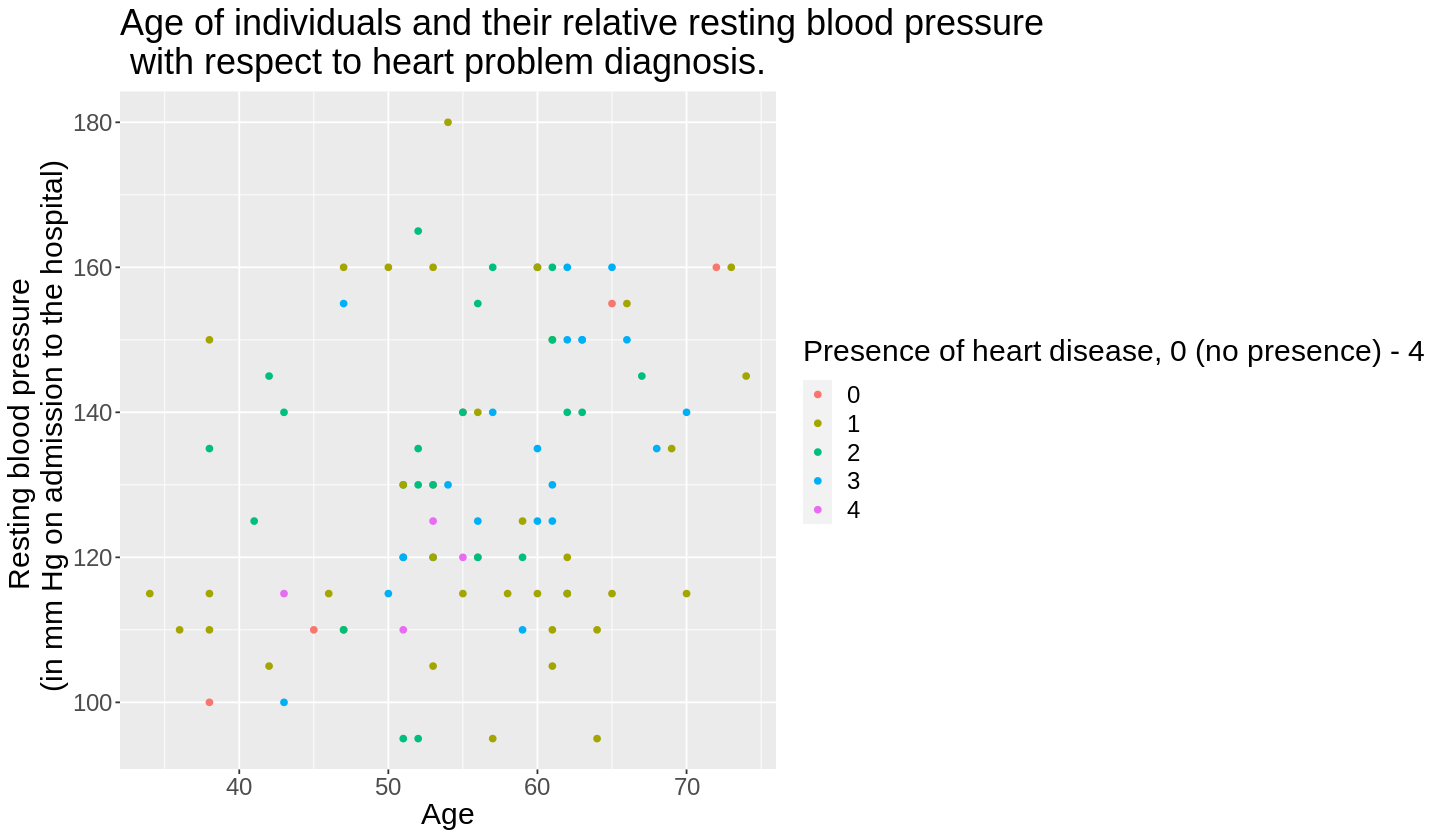

In [5]:
names <- c('age', 'sex', 'chest_pain', 'rest_bp', 'cholestoral_mmHg', 'fasting_bs', 
           'rest_ECG', 'max_heart_rate', 'exercise', 'ST_dep', 'slope', 'major_vessels', 'thal', 'diagnosis')

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data"
heart_data <- read_csv(url, col_names = names) %>% # Reading in the data
    na_if('?') # removing question marks and replacing with NA

# removing the rows we are not using and turning all columns into the values we need.
heart_data <- heart_data %>%
    mutate(sex = as.factor(sex), chest_pain = as.factor(chest_pain), fasting_bs = as.factor(fasting_bs),
           rest_ECG = as.factor(rest_ECG), max_heart_rate = as.factor(max_heart_rate),
           exercise = as.factor(exercise), major_vessels = as.factor(major_vessels), 
           thal = as.factor(thal), diagnosis = as.factor(diagnosis), rest_bp = as.numeric(rest_bp)) %>%
    select(-slope, -ST_dep, -cholestoral_mmHg) # What we are excluding
heart_data

# Is this data 'tidy'? YES!

# Make training data and testing data:
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# glimpse(heart_train)
# glimpse(heart_test)

# proportions of each set of data compared to the original
heart_proportions_train <- heart_train %>%
    group_by(diagnosis) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/nrow(heart_train))
# heart_proportions_train

heart_proportions <- heart_data %>%
    group_by(diagnosis) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/nrow(heart_data))
# heart_proportions

heart_proportions_test <- heart_test %>%
    group_by(diagnosis) %>%
    summarize(n = n()) %>%
    mutate(percent = 100*n/nrow(heart_test))
# heart_proportions_test

# Table to present of training data:
heart_summary_data <- heart_train %>%
    group_by(diagnosis) %>%
    summarise(Count = n())
heart_summary_data

# how many rows have missing data 
sum(!complete.cases(heart_train))
head(apply(heart_train, 1, anyNA))

# training data visualization:
options(repr.plot.height = 7, repr.plot.width = 12)
plot_heart_train_bp <- heart_train %>%
                    ggplot(aes(x=age, y=rest_bp, color=diagnosis)) +
                    geom_point() +
                    labs(x="Age", 
                         y="Resting blood pressure \n (in mm Hg on admission to the hospital)", 
                         color="Presence of heart disease, 0 (no presence) - 4") +
                    ggtitle('Age of individuals and their relative resting blood pressure \n with respect to heart problem diagnosis.') +
                    theme(text = element_text(size = 18))
plot_heart_train_bp

## Methods

Tidy our data. Split our data into training and testing sets. Conduct knn classifier steps to train our training data and predict our hypothesis. Use our chosen variables to set up and test the accuracy. Create visualizations with our variables and combine the visualizations to help show our answer. In our report, we will visualize the results by creating a scatter plot with the resting blood pressure and age on the X and Y axes, with colour being the degree of heart disease and shape being the presence of exercise induced angina. Our visualization will be similar to the one included in this proposal but additionally will map the zones of heart disease level. 


## Expected Outcomes and Significance

**What do you expect to find?**

We expect to find that the larger the numerical value of a person’s age, resting blood pressure, chest pain, and maximum heart rate, the greater at risk a person is to have worsened heart disease.

**What impact could such findings have?**

This could give us an idea of which type of person is most at risk of developing severe heart disease. Further, this research could lead to a better diagnosis for people, and therefore less death and less cost.

**What future Questions could this lead to?**

How could heart disease be lessened in the future or how can heart disease be prevented?

## References

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., Lee, S., and Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American Journal of Cardiology, 64*(5), 304-310. https://doi.org/10.1016/0002-9149(89)90524-9

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. Heart Disease Data Set created by William Steinbrunn, M.D. from University Hospital, Zurich, Switzerland and Matthias Pfisterer, M.D. from University Hospital, Basel, Switzerland.

National Center for Chronic Disease Prevention and Health Promotion , Division for Heart Disease and Stroke Prevention. (2022, February 7). *Heart Disease Facts*. Retrieved March 5, 2022, from https://www.cdc.gov/heartdisease/facts.htm